In [1]:
data_dir = "/data/projects/dschaub/ANCA-GN_transcriptomics/data/single-cell"
working_dir = "/data/projects/dschaub/ANCA-GN_transcriptomics"

In [2]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(working_dir)

import yaml
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import numpy as np
import scanpy as sc
from scipy import sparse
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import font_manager

from utils.utils import *
from utils.plotting import *
from utils.py2r import *

sc.settings.verbosity = 0
sc.settings._vector_friendly = True
font_dirs = "/usr/share/fonts/truetype/msttcorefonts/"
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = "arial"
plt.rcParams['font.size'] = 12
# sc.set_figure_params(transparent=True)

Global seed set to 0
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


## Load data

In [3]:
path = os.path.join(
    data_dir, "exploratory/ANCA_exploratory_27PK27PB_Tcells_HarmonyR_annotated.h5mu"
)
mudata = md.read_h5mu(path)
mod_rna = mudata.mod["rna"]
mod_cite = mudata.mod["cite"]

path = os.path.join(
    data_dir, "exploratory/ANCA_exploratory_27PK27PB_CD4Teff_annotated.h5mu"
)
mudata_cd4 = md.read_h5mu(path)
mod_rna_cd4 = mudata_cd4.mod["rna"]
mod_cite_cd4 = mudata_cd4.mod["cite"]

path = os.path.join(
    data_dir, "exploratory/ANCA_exploratory_27PK27PB_CD8Teff_annotated.h5mu"
)
mudata_cd8 = md.read_h5mu(path)
mod_rna_cd8 = mudata_cd8.mod["rna"]
mod_cite_cd8 = mudata_cd8.mod["cite"]

In [5]:
mudata

MuData object with n_obs × n_vars = 72416 × 21625
  2 modalities
    rna:	72416 x 21419
      obs:	'patient', 'sample', 'tissue', 'cell_type_yu', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'leiden_1.1', 'leiden_1.2', 'leiden_1.3', 'leiden_1.4', 'leiden_1.5', 'leiden_1.6', 'leiden_1.7', 'leiden_1.8', 'leiden_1.9', 'cell_type', 'cell_type_v1'
      var:	'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
      uns:	'cell_type_colors', 'cell_type_v1_colors', 'cell_type_yu_colors', 'leiden', 'leiden_0.3_colors', 'leiden_0.4_colors', 'leiden_0.5_colors', 'leiden_0.6_colors', 'leiden_0.7_colors', 'leiden_0.8_colors', 'leiden_0.9_colors', 'leiden_1.0_colors', 'leiden_1.1_colors', 'leiden_1.2_colors', 'leiden_1.3_colors', 'leiden_1.4_colors', 'leiden_1.5_colors', 'leiden_1.6_colors', 'leiden_1.7_colors', 'leiden_1.8_colors', 'leiden_1.9_colors', 'log1p', 'neighbors', 'patient_colors', 'sample_colors', 'tissue_colors', 'umap'
      obsm:	'X_harmony', 'X_umap'
      layers:	'counts', 'log1p', 'scaled'
      obsp:	'connectivities', 'distances'
    cite:	72416 x 206
      obs:	'patient', 'sample', 'tissue', 'cell_type_yu', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
      var:	'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
      layers:	'clr', 'counts', 'scaled'

In [6]:
mod_rna.obs["cell_type_v1_merged"] = mod_rna.obs["cell_type_v1"].astype(str)
mod_rna.obs.loc[mod_rna_cd4.obs_names, "cell_type_v1_merged"] = mod_rna_cd4.obs[
    "cell_type_fine"
].astype(str)

mod_rna.obs.loc[mod_rna_cd8.obs_names, "cell_type_v1_merged"] = mod_rna_cd8.obs[
    "cell_type_fine"
].astype(str)

mod_rna.obs["cell_type_v1_merged"] = mod_rna.obs["cell_type_v1_merged"].astype(
    "category"
)

In [21]:
# remove any cell that are not contained in the cd8 dataset
# mask = (mod_rna.obs["cell_type"] == "CD8+ EM/RM") & ~mod_rna.obs_names.isin(
#     mod_rna_cd8.obs_names
# )
# mod_rna = mod_rna[~mask]
# mod_cite = mod_cite[~mask]
# mudata = md.MuData({"rna": mod_rna, "cite": mod_cite})

In [22]:
mod_rna

AnnData object with n_obs × n_vars = 72416 × 21419
    obs: 'patient', 'sample', 'tissue', 'cell_type_yu', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'leiden_1.1', 'leiden_1.2', 'leiden_1.3', 'leiden_1.4', 'leiden_1.5', 'leiden_1.6', 'leiden_1.7', 'leiden_1.8', 'leiden_1.9', 'cell_type', 'cell_type_v1', 'cell_type_v1_merged'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'cell_type_colors', 'cell_type_v1_colors', 'cell_type_yu_colors', 'leiden', 'leiden_0.3_colors', 'leiden_0.4_colors', 'leiden_0.5_colors', 'leiden_0.6_colors', 'leiden_0.7_colors', 'leiden_0.8_colors', 'leiden_0.9_colors', 'leiden_1.0_colors', 'leiden_1.1_colors', 'leiden_1.2_colors', 'leiden_1.3_colors', 'leiden_1.4_colors', 'leiden_1.5_colors

## Visualizations

In [7]:
celltype_col = "cell_type_v1"

celltype_map = dict(zip(mod_rna.obs["cell_type"], mod_rna.obs[celltype_col]))

### Umap

In [8]:
color_map = {
    "CD4+ naive": "#1f77b4",
    "CD4+/CD8+ CM": "#ff7f0e",
    "NKT/CTL": "#279e68",
    "CD4+ EM/RM": "#d62728",
    "CD8+ EM/RM": "#aa40fc",
    "CD8+ CM/EM": "#8c564b",
    "CD4+/CD8+ stressed": "#e377c2",
    "Treg": "#b5bd61",
    "CD8+ naive": "#17becf",
    "MAIT": "#ffbb78",
    "Prolif.": "#98df8a",
    "NKT": "#aec7e8",
    "gdT": "#c5b0d5",
    "CD4+ CM": "#ff9896",
    "NK": "#c49c94",
}
color_map = {celltype_map[k]: v for k, v in color_map.items()}

cmap_cd8 = {
    "Tc1": "#6600B4",
    "Tc1-like": "#840AE2",
    "Tc17-like": "#A228FF",
    "Th1-like": "#CEB9DE",
    "NKT/CTL": "#D2D2D2",
}

cmap_cd8 = {
    "Tc1": "#6600B4",
    "Tc17-like": "#840AE2",
    "Th1-like": "#A228FF",
    "NKT/CTL": "#D2D2D2",
}


cmap_cd4 = {
    "Th17": "#7B1717",
    "Th1": "#A91F1F",
    "Tfh": "#E0B093",
    "Th1-like": "#D62728",
    "Tc1-like": "#D2D2D2",
}

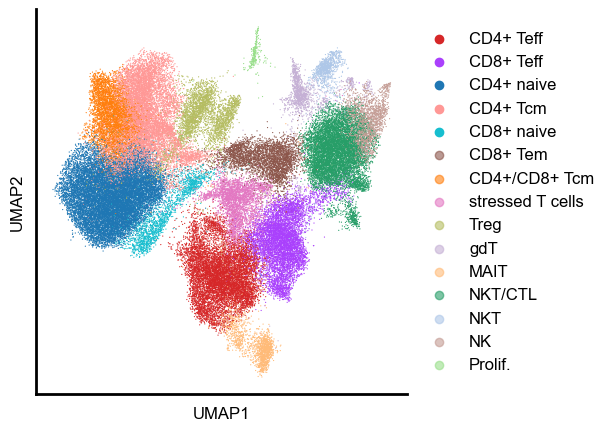

In [10]:
order = [
    "CD4+ EM/RM",
    "CD8+ EM/RM",
    "CD4+ naive",
    "CD4+ CM",
    "CD8+ naive",
    "CD8+ CM/EM",
    "CD4+/CD8+ CM",
    "CD4+/CD8+ stressed",
    "Treg",
    "gdT",
    "MAIT",
    "NKT/CTL",
    "NKT",
    "NK",
    "Prolif.",
]
order = [celltype_map[x] for x in order]
colors = [color_map[x] for x in order]
orig_col = mod_rna.obs[celltype_col].copy()
mod_rna.obs["cell_type_umap"] = pd.Categorical(
    mod_rna.obs[celltype_col], categories=order, ordered=True
)
plot_umap(
    mod_rna,
    color="cell_type_umap",
    palette=colors,
    figsize=(5.5, 5),
    title="",
    size=3,
    axes_fraction=1.0,
    save_path="figures/main/exploratory_umap.pdf",
)

### Tissue composition

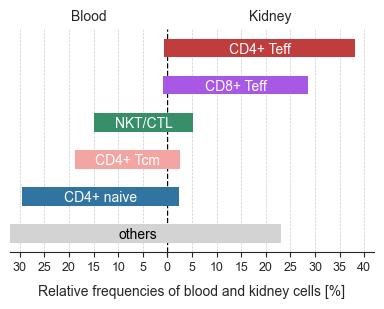

In [11]:
celltypes_to_keep = ["CD4+ EM/RM", "CD8+ EM/RM", "NKT/CTL", "CD4+ CM", "CD4+ naive"]
celltypes_to_keep = [celltype_map[x] for x in celltypes_to_keep]
replacements = {
    x: (x if x in celltypes_to_keep else "others")
    for x in mod_rna.obs[celltype_col].unique()
}
mod_rna.obs["cell_type_agg"] = mod_rna.obs[celltype_col].replace(replacements)
color_map_agg = {k: color_map[k] for k in celltypes_to_keep}
color_map_agg["others"] = "lightgrey"

plot_tissue_compostion(
    mod_rna,
    color_map_agg,
    celltype_key="cell_type_agg",
    tissue_key="tissue",
    label_order=None,
    use_rel_values=True,
    figsize=(4, 3),
    save_path="figures/main/exploratory_tissue_composition_small.pdf",
)

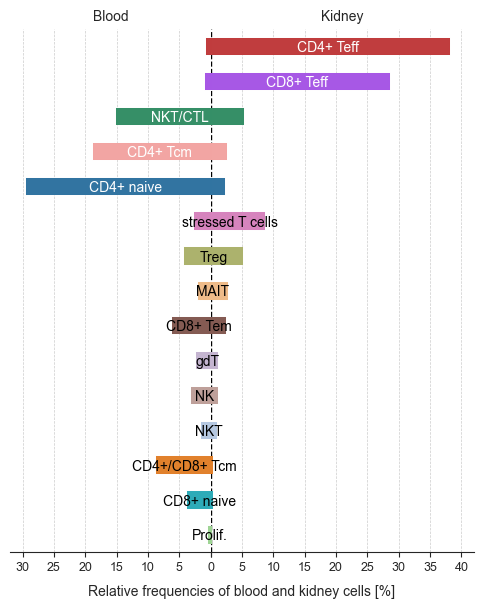

In [12]:
plot_tissue_compostion(
    mod_rna,
    color_map,
    celltype_key=celltype_col,
    tissue_key="tissue",
    label_order=celltypes_to_keep,
    use_rel_values=True,
    figsize=(5, 6),
    save_path="figures/main/exploratory_tissue_composition_full.pdf",
)

### EM/RM subsets

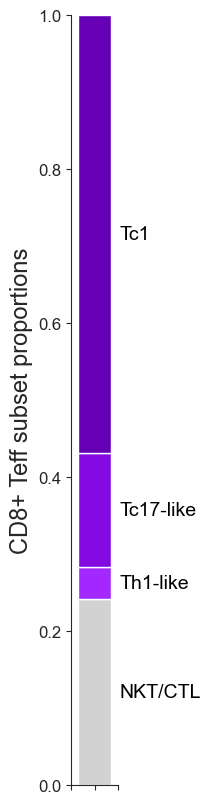

In [13]:
labels_cd8 = [
    "Tc1",
    # "Tc1-like",
    "Tc17-like",
    "Th1-like",
    "NKT/CTL",
]
plot_single_stacked_bar(
    mod_rna_cd8,
    labels=labels_cd8,
    color_map=cmap_cd8,
    celltype_col="cell_type_fine_v1",
    save_path="figures/main/exploratory_cd8_stacked_bar.pdf",
    ylabel="CD8+ Teff subset proportions",
)

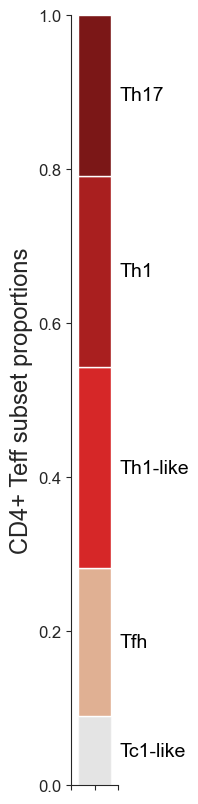

In [14]:
labels_cd4 = [
    "Th17",
    "Th1",
    "Th1-like",
    "Tfh",
    "Tc1-like",
]
plot_single_stacked_bar(
    mod_rna_cd4,
    labels=labels_cd4,
    color_map=cmap_cd4,
    celltype_col="cell_type_fine",
    save_path="figures/main/exploratory_cd4_stacked_bar.pdf",
    ylabel="CD4+ Teff subset proportions",
)

### Gene scores

In [15]:
th1_genes = [
    "IFNG",
    "IL2",
    "TNF",
    "LTA",
    "CSF2",
    "IL18",
]
th2_genes = [
    "IL4",
    "IL5",
    "IL9",
    "IL13",
    # "IL10",
    # "IL21",
    # "IL6",
]
th17_genes = ["IL17A", "IL17F", "IL22", "IL26"]

gene_list = th1_genes + th2_genes + th17_genes

mod_rna.X = mod_rna.layers["scaled"].copy()

cytokine_markers = gene_list
sc.tl.score_genes(
    mod_rna,
    gene_list=cytokine_markers,
    score_name="cytokine_score",
    ctrl_size=50,
    use_raw=False,
)
sc.tl.score_genes(
    mod_rna,
    gene_list=th1_genes,
    score_name="type1_score",
    ctrl_size=50,
    use_raw=False,
)
sc.tl.score_genes(
    mod_rna,
    gene_list=th2_genes,
    score_name="type2_score",
    ctrl_size=50,
    use_raw=False,
)
sc.tl.score_genes(
    mod_rna,
    gene_list=th17_genes,
    score_name="type3_score",
    ctrl_size=50,
    use_raw=False,
)
mod_rna.X = mod_rna.layers["log1p"].copy()

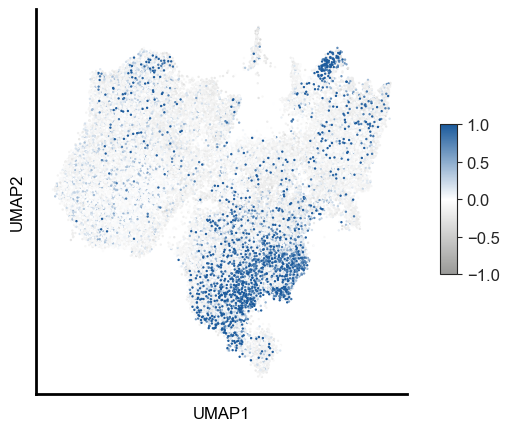

In [16]:
# Define the colors for the colormap (light grey to blue)
colors = [
    # "#E6E6E3",
    "#999997",
    # "lightgrey",
    "white",
    [0.10572856593617842, 0.35432525951557103, 0.6110726643598616],
]
cmap_name = "custom_lightgrey_blue"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

plot_scores(
    mod_rna,
    figsize=(5.5, 5),
    score="cytokine_score",
    # title=None,
    # title="Cytokine score",
    cmap=custom_cmap,
    save_path="figures/main/exploratory_cytokine_score.pdf",
)

In [17]:
scores = mod_rna.obs[["type1_score", "type2_score", "type3_score"]].copy()

In [18]:
mod_rna.obs[["type1_score", "type2_score", "type3_score"]] = scores.copy()

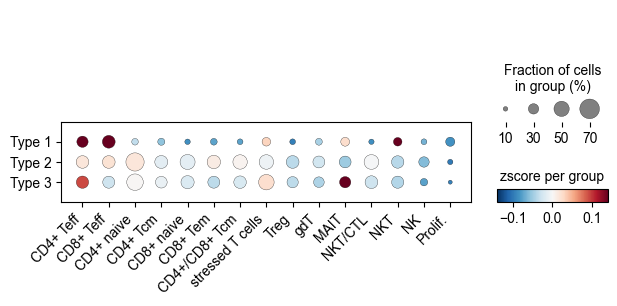

In [19]:
groupby = "cell_type_agg"
groupby = celltype_col

if groupby == "cell_type_agg":
    order = ["CD4+ Teff", "CD8+ Teff", "NKT/CTL", "CD4+ Tcm", "CD4+ naive", "others"]

    mod_rna.obs[groupby] = pd.Categorical(
        mod_rna.obs[groupby], categories=order, ordered=True
    )
else:
    order = [
        "CD4+ EM/RM",
        "CD8+ EM/RM",
        "CD4+ naive",
        "CD4+ CM",
        "CD8+ naive",
        "CD8+ CM/EM",
        "CD4+/CD8+ CM",
        "CD4+/CD8+ stressed",
        "Treg",
        "gdT",
        "MAIT",
        "NKT/CTL",
        "NKT",
        "NK",
        "Prolif.",
    ]
    order = [celltype_map[x] for x in order]
    mod_rna.obs[celltype_col] = pd.Categorical(
        mod_rna.obs[celltype_col], categories=order, ordered=True
    )
fig = sc.pl.dotplot(
    mod_rna,
    var_names=["type1_score", "type2_score", "type3_score"],
    # groupby="cell_type_agg",
    groupby=groupby,
    color_map="RdBu_r",
    vmin=-0.14,
    vmax=0.14,
    # return_fig=True,
    show=False,
    # title="",
    # size_title=0,
    # figsize=(5, 1.5),
    colorbar_title="zscore per group",
    swap_axes=True,
)
ax = fig["mainplot_ax"]
ax.set_yticklabels(["Type 1", "Type 2", "Type 3"], rotation=0)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.savefig(
    "figures/main/exploratory_cytokine_score_dotplot.pdf",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)
plt.show()